In [1]:
import geemap
from geemap import colormaps
from geemap import foliumap
import ee
import sys
sys.path.append('C:/Users/wb514197/Repos/GEE_Zonal/src')
from gee_tools import Catalog, ZonalStats
import pandas as pd
import os
import glob
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv, find_dotenv
import datapane as dp
from matplotlib import pyplot as plt

In [2]:
ee.Initialize()

In [16]:
center_lat = 7.993471334318632
center_lon = 98.33515214624994
zoomlevel=10

# initialize our map
Map = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)

In [17]:
Map.addLayerControl()
Map

Map(center=[7.993471334318632, 98.33515214624994], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
# the first time I drew the bounding box to capture coordinates
# aoi = ee.FeatureCollection(Map.draw_features)
# aoi.getInfo()

In [5]:
aoi = ee.FeatureCollection({'type': 'FeatureCollection',
 'columns': {'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'geodesic': False,
    'type': 'Polygon',
    'coordinates': [[[98.117499, 7.657021],
      [98.117499, 8.309809],
      [98.528199, 8.309809],
      [98.528199, 7.657021],
      [98.117499, 7.657021]]]},
   'id': '0',
   'properties': {}}]})

In [6]:
pal = colormaps.get_palette('viridis', 20)

In [7]:
vis_params = {
    'bands': ['avg_rad'], 
    'palette': pal, 
    'min': 0.0, 
    'max': 60.0, 
    'opacity': 1.0
}
# vis_params = {"min": 0,
#               "max": 100,
#               "bands": ["B8", "B4", "B3"]}

In [9]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad').filterDate('2020-01-01', "2021-06-01")
one = viirs.first().clip(aoi)
one = one.mask(one)

In [10]:
Map.addLayer(one, vis_params, 'Viirs')

In [10]:
# l = Map.find_layer('Viirs')
# layers = Map.layers
# layers[2].name

In [13]:
# to remove
Map.remove_layer(Map.find_layer('Viirs'))

In [9]:
Map

Map(center=[7.993471334318632, 98.33515214624994], controls=(WidgetControl(options=['position', 'transparent_b…

In [53]:
zs = ZonalStats(
    collection_id='NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features=aoi,
    statistic_type='sum',
    output_name='',
    scale=500,
    min_threshold=0,
    water_mask=False,
    start_year=2018,
    end_year=2022,
    frequency='original',
    temporal_stat=None,
    band='avg_rad',
    output_dir='',
)

In [68]:
res = zs.runZonalStats()

In [69]:
# geemap.ee_export_vector(res, "test_res.csv")

In [70]:
res = res.getInfo()

In [71]:
feats = res['features']
cols = [list(f['properties'].keys()) for f in feats][0]
# res['columns'].pop('system:index')
# cols = list(res['columns'].keys())
ids = [f['id'] for f in feats]
values = [list(f['properties'].values()) for f in feats]

In [72]:
df = pd.DataFrame(index=ids, columns=cols, data=values)

In [73]:
def rename_func(col):
    p = col.split("_")
    new_name = "rad_sum"+"__"+p[0]
    return new_name

In [74]:
df.rename(rename_func, axis=1, inplace=True)

In [75]:
df

,rad_sum__20180101,rad_sum__20180201,rad_sum__20180301,rad_sum__20180401,rad_sum__20180501,rad_sum__20180601,rad_sum__20180701,rad_sum__20180801,rad_sum__20180901,rad_sum__20181001,...,rad_sum__20200701,rad_sum__20200801,rad_sum__20200901,rad_sum__20201001,rad_sum__20201101,rad_sum__20201201,rad_sum__20210101,rad_sum__20210201,rad_sum__20210301,rad_sum__20210501
0,28130.781996,27184.385777,27483.034286,29311.177311,2805.793487,8173.382541,24591.406972,26336.7996,24976.751477,21914.102358,...,22042.146003,26066.274293,10270.127467,33924.938353,12551.1328,30809.919995,31659.853562,31586.14736,32451.749174,21881.611714


In [76]:
df.reset_index(inplace=True)

In [79]:
df_re = pd.wide_to_long(
    df,
    stubnames = ['rad_sum'],
    i = 'index',
    j = 'date',
    sep = "__"
)

In [81]:
df_re.reset_index(inplace=True)

In [82]:
df_re.loc[:,"date"] = pd.to_datetime(df_re.date, format="%Y%m%d")

In [83]:
sns.set()

<AxesSubplot:xlabel='date', ylabel='rad_sum'>

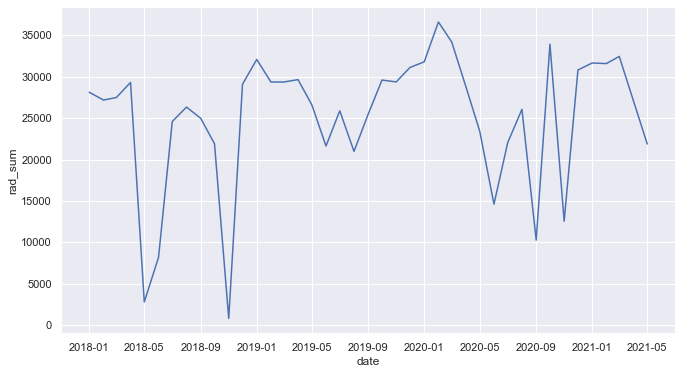

In [85]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re, x="date", y="rad_sum")

In [87]:
zs = ZonalStats(
    collection_id='NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features=aoi,
    statistic_type='mean',
    output_name='',
    scale=500,
    min_threshold=0,
    water_mask=False,
    start_year=2018,
    end_year=2022,
    frequency='original',
    temporal_stat=None,
    band='avg_rad',
    output_dir='',
)
res = zs.runZonalStats()
res = res.getInfo()
feats = res['features']
cols = [list(f['properties'].keys()) for f in feats][0]
ids = [f['id'] for f in feats]
values = [list(f['properties'].values()) for f in feats]
df = pd.DataFrame(index=ids, columns=cols, data=values)
def rename_func(col):
    p = col.split("_")
    new_name = "rad_mean"+"__"+p[0]
    return new_name
df.rename(rename_func, axis=1, inplace=True)
df.reset_index(inplace=True)
df_re2 = pd.wide_to_long(
    df,
    stubnames = ['rad_mean'],
    i = 'index',
    j = 'date',
    sep = "__"
)
df_re2.reset_index(inplace=True)
df_re2.loc[:,"date"] = pd.to_datetime(df_re.date, format="%Y%m%d")

<AxesSubplot:xlabel='date', ylabel='rad_mean'>

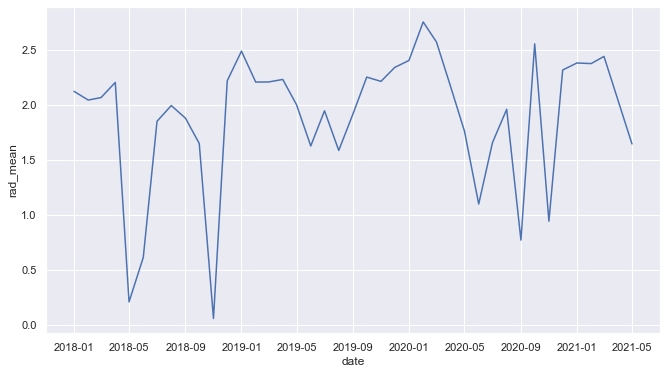

In [91]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_re2, x="date", y="rad_mean")

In [8]:
viirs_col = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', "2021-06-01")

In [9]:
def prepareImage(img):
    img_clip = img.clip(aoi)
    img_masked = img_clip.mask(img_clip)
    return img_masked

In [10]:
viirs_col_clip = viirs_col.map(prepareImage)

In [11]:
# def ymList_ee(self):
#     '''
#     Create list of year/month pairs from a given dataset using EE
#     '''
#     def iter_func(image, newlist):
#         date = image.date().format("YYYY-MM")
#         return newlist.append(date)
#     ymd = self.iterate(iter_func, [])
#     return ymd

In [12]:
def ymList_ee(self):
    '''
    Create list of year/month pairs from a given dataset using EE
    '''
    def iter_func(image, newlist):
        date = ee.String(image.date().format("YYYY-MM"))
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = self.iterate(iter_func, ee.List([]))
    return ee.List(ymd).distinct()

In [13]:
dates = ymList_ee(viirs_col_clip)

In [14]:
dates = dates.getInfo()

In [18]:
Map.add_time_slider(viirs_col_clip, vis_params, labels=dates, time_interval=2.628e+6)

In [19]:
Map

Map(bottom=125532.0, center=[7.993471334318632, 98.33515214624994], controls=(WidgetControl(options=['position…

In [23]:
out = os.path.join(os.getcwd(), "map_test.html")

In [24]:
Map.to_html(outfile=out)

In [22]:
os.getcwd()

'C:\\Users\\wb514197\\Repos\\Lights_Sandbox\\notebooks'

In [20]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
dp_token = os.environ.get("DP_TOKEN")

In [23]:
dp.login(token=dp_token)

Connected successfully to https://datapane.com as andres64


'andres64'

In [28]:
!conda list geemap

# packages in environment at C:\WBG\Anaconda\envs\ee:
#
# Name                    Version                   Build  Channel
geemap                    0.8.18             pyhd8ed1ab_0    conda-forge


In [25]:
# Map.publish(name='Phuket Night Lights', description='A folium map with Earth Engine data layers', visibility='PUBLIC')